In [1]:
import fitsio
from fitsio import FITS, FITSHDR
from astropy import wcs
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

from kernels import eval_cubic_kernel, cubic_shift_image, eval_cubic_interpolation

In [2]:
git_path = os.environ['GIT_REPO_LOC']
data_path = os.path.join(git_path, 'DECamSurvey.jl/dat')
image_filename = os.path.join(data_path, 'c4d_160302_094418_oki_z_v1.fits')
mask_filename = os.path.join(data_path, 'c4d_160302_094418_ood_z_v1.fits')
dr3_object = fitsio.read_header(image_filename)['OBJECT']

In [77]:
# Load an image.
image_index = 3
image = fitsio.read(image_filename, ext=image_index)
image_mask = fitsio.read(mask_filename, ext=image_index)
header = fitsio.read_header(image_filename, ext=image_index)
im_wcs = wcs.WCS(header)
avsky = header["AVSKY"]

print 'Good pixel proportion:'
print np.sum(image_mask == 0) / float(np.prod(image_mask.shape))
image[image_mask == 1] = float('nan')
# plt.matshow(np.log10(image), interpolation="nearest")
# plt.colorbar()

1857.90132203
Good pixel proportion:
0.974422192838


In [4]:
# Load the catalog.

def get_brick_names_for_image(header, brick_filename):
    # First select the bricks that overlap with the image.
    ra_corners = [ header['COR%dRA1' % (i + 1)] for i in range(4)]
    dec_corners = [ header['COR%dDEC1' % (i + 1)] for i in range(4)]
    brick_select = \
      'ra2 > {ramin} && ra1 < {ramax} && dec2 > {decmin} && dec1 < {decmax}'.format(
          ramin=np.min(ra_corners), ramax=np.max(ra_corners),
          decmin=np.min(dec_corners), decmax=np.max(dec_corners))

    brick_fits = fitsio.FITS(brick_filename)
    keep_rows = brick_fits[1].where(brick_select) 
    bricks = brick_fits[1]['brickname'][keep_rows]
    brick_fits.close()
    
    return bricks

brick_filename = os.path.join(data_path, 'survey-bricks.fits')
bricks = get_brick_names_for_image(header, brick_filename)
print bricks


['1984p110' '1986p110' '1984p112' '1987p112']


In [5]:
def load_catalog(tractor_filename):
    tractor_fits = fitsio.FITS(tractor_filename)
    tractor_header = fitsio.read_header(tractor_filename, ext=1)
    catalog_cols = [ 'type', 'ra', 'dec', 'cpu_source', 'decam_flux', 'wise_flux',
                      'fracdev', 'shapeexp_r', 'shapedev_r' ]

    objid = tractor_fits[1]['objid'][:]

    catalog_df = pd.DataFrame({'objid': objid})
    for catalog_col in catalog_cols:
        tractor_data = tractor_fits[1][catalog_col][:]
        if len(tractor_data.shape) == 1:
            catalog_df[catalog_col] = tractor_data
        else:
            for col in range(tractor_data.shape[1]):
                catalog_df[catalog_col + str(col + 1)] = tractor_data[:, col]

    return catalog_df

tractor_filenames = \
    [ os.path.join(data_path, 'tractor-{brickname}.fits'.format(brickname=brick)) \
      for brick in bricks]

catalog_df = pd.concat([ load_catalog(fname) for fname in tractor_filenames ])

# Have to trim whitespace from the type for some reason.
catalog_df['type'] = catalog_df['type'].map(lambda t: t.strip())

print catalog_df.shape

(11122, 18)


In [6]:
# Filter the catalog to objects located in the current image.  Note that,
# unlike Julia, I will use zero indexing to match Python.
pix = im_wcs.wcs_world2pix(catalog_df[['ra', 'dec']].as_matrix(), 0)

# Note that the image is transposed relative to Julia, so the image is indexed [pix_w, pix_h].
print np.min(pix, 0)
print np.max(pix, 0)
print image.shape

row_in_image = \
    np.logical_and.reduce([ pix[:, 0] >= 0,
                            pix[:, 0] <= image.shape[1] - 1,
                            pix[:, 1] >= 0,
                            pix[:, 1] <= image.shape[0] - 1 ])

catalog_df = catalog_df[row_in_image]
catalog_df['pix_h'] = pix[row_in_image, 0]
catalog_df['pix_w'] = pix[row_in_image, 1]
print catalog_df.shape

[-3158.23405395 -1956.63426665]
[ 3865.51047988  5399.76275359]
(4094, 2046)
(2088, 20)


In [7]:
# Display the catalog objects.
bright_rows = catalog_df['decam_flux5'] > 300

plt.matshow(np.log10(image))
plt.colorbar()
plt.plot(catalog_df[bright_rows]['pix_h'], catalog_df[bright_rows]['pix_w'], 'ro')

<IPython.core.display.Javascript object>

In [8]:
# This is an L_\infty "radius".
def get_pixel_box(pix_h, pix_w, pix_radius, image_shape):
    h_min = np.max([int(np.floor(pix_h - pix_radius)), 0])
    w_min = np.max([int(np.floor(pix_w - pix_radius)), 0])
    h_max = np.min([int(np.ceil(pix_h + pix_radius)), image_shape[1]])
    w_max = np.min([int(np.ceil(pix_w + pix_radius)), image_shape[0]])

    return slice(h_min, h_max), slice(w_min, w_max)
        
h_slice, w_slice = get_pixel_box(3, 100.1, 3.1, image.shape)
print image[w_slice, h_slice]

[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


In [9]:
# Filter out galaxy pixels.

filter_image = copy.deepcopy(image)
# print [ type.strip() for type in catalog_df['type'] ]
# gal_rows = [ type.strip() == 'PSF' for type in catalog_df['type'] ] 
gal_rows = catalog_df['type'] != 'PSF'

print 'Proportion of objects that are galaxies:'
print np.sum(gal_rows) / float(catalog_df.shape[0])

for index, row in catalog_df[gal_rows].iterrows():
    # These radii are in pixels.
    radius = np.max([8 * row['shapedev_r'], 8 * row['shapeexp_r'], 3.0])
    h_slice, w_slice = get_pixel_box(row['pix_h'], row['pix_w'], radius, filter_image.shape)
    filter_image[w_slice, h_slice] = float('nan')


Proportion of objects that are galaxies:
0.528735632184


In [10]:
plt.matshow(np.log10(filter_image))
plt.colorbar()
#plt.plot(catalog_df[gal_rows]['pix_h'], catalog_df[gal_rows]['pix_w'], 'ro')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


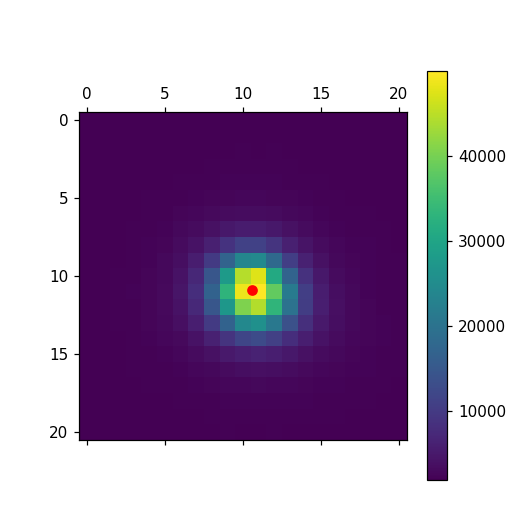

In [39]:
bright_star_rows = np.logical_and(catalog_df['type'] == 'PSF', catalog_df['decam_flux5'] > 300)
row = catalog_df[bright_star_rows].iloc[0]
h_slice, w_slice = get_pixel_box(row['pix_h'], row['pix_w'], 10, filter_image.shape)
plt.matshow(filter_image[w_slice, h_slice])
star_pix_loc = [row['pix_w'] - w_slice.start, row['pix_h'] - h_slice.start]
plt.plot(star_pix_loc[0], star_pix_loc[1], 'ro')
plt.colorbar()

<IPython.core.display.Javascript object>


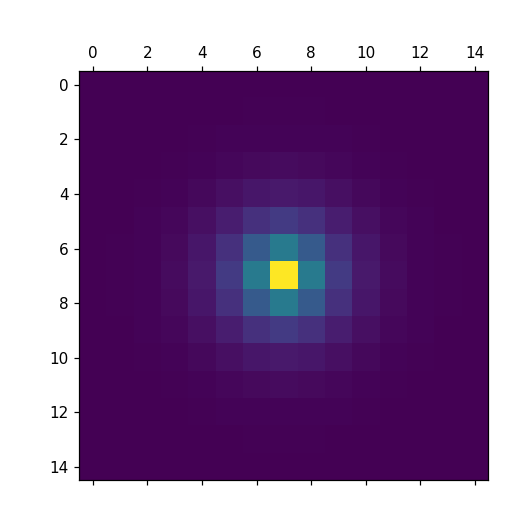

In [83]:
# Make a little gaussian image for a PSF.

psf_size = 15
psf_image = np.zeros([psf_size, psf_size])
psf_center = np.array([ 0.5 * (float(psf_image.shape[0]) - 1), 0.5 * (float(psf_image.shape[1]) - 1)])
gauss_loc = np.array(psf_center)
gauss_var = 0.75**2
for x, y in np.ndindex(psf_image.shape):
    psf_image[x, y] = np.exp(-0.5 * np.linalg.norm(np.array([x, y]) - gauss_loc) / gauss_var)
plt.matshow(psf_image)


<IPython.core.display.Javascript object>


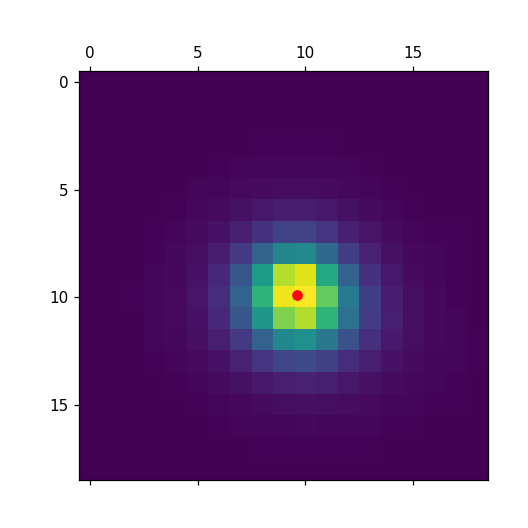

In [67]:
star_loc_offset = star_pix_loc - psf_center
star_int_offset = [ int(np.floor(x)) for x in star_loc_offset ]
star_delta = star_loc_offset - star_int_offset

# This slice is where the interpolated PSF would go in the star image if the star_delta were zero.
# Add a two row2 to each side for the interpolation.
w_psf_slice = slice(star_int_offset[0] - 2, star_int_offset[0] + psf_image.shape[0] + 2)
h_psf_slice = slice(star_int_offset[1] - 2, star_int_offset[1] + psf_image.shape[1] + 2)
plt.matshow(filter_image[w_slice, h_slice][w_psf_slice, h_psf_slice])
plt.plot(star_delta[0] + psf_center[0] + 2, star_delta[1] + psf_center[1] + 2, 'ro')


<IPython.core.display.Javascript object>


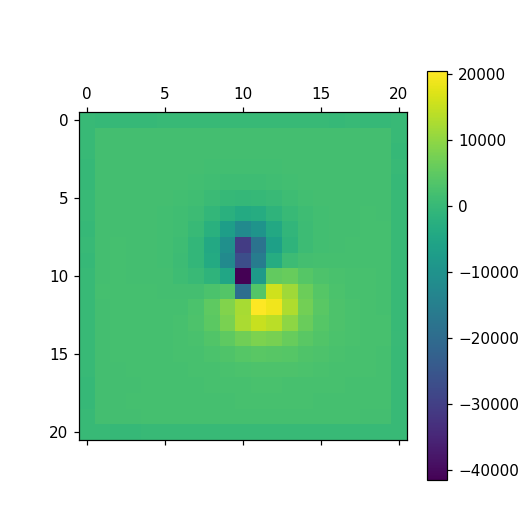

In [103]:
star_image = np.zeros_like(filter_image[w_slice, h_slice])
star_image.fill(avsky)
cubic_shift_image(star_delta, 150000.0 * psf_image, star_image[w_psf_slice, h_psf_slice], 2.0)

plt.matshow(filter_image[w_slice, h_slice] - star_image )
plt.colorbar()
